# Get dataset with fingerprints

# Remove repeated chemicals in the train/score dataset (skip if reloading)

In [1]:
import os, sys
import pandas as pd
import numpy as np
df = pd.read_csv("XY_Tox21_CDKPaDEL_processed.csv")

label_start = 5
feat_start = 17
train_ind = np.where(np.isin(df['Type'], ['Training', 'Testing']))[0]
test_ind = np.where(df['Type']=='Score')[0]
labels = df.columns[label_start:feat_start].values

In [2]:
smi = df['Canonical_QSARr'].values
train_smi = smi[train_ind]
train_labels = df.iloc[train_ind, label_start:feat_start].values

def combine_labels(labels):
    r = []
    for i in range(labels.shape[1]):
        l = labels[:, i]
        l = l[np.isfinite(l)]
        if len(np.unique(l))==1:
            r.append(np.unique(l))
        else: #No labels, or more than 1 unique label
            r.append(np.nan)
    return np.array(r).ravel()

In [3]:
repeated_ind=[]
for i in range(train_labels.shape[0]):
    if np.isin([i],repeated_ind)[0]:
        continue
    rep = np.where(train_smi==train_smi[i])[0]
    if len(rep)>1:
        train_labels[i] = combine_labels(train_labels[rep])
        repeated_ind=np.concatenate([repeated_ind, 
                                     np.setdiff1d(rep, [i])])
retain_ind = np.setdiff1d(train_ind,
                          repeated_ind
                         )
updated_train_labels = train_labels[retain_ind,:]

<ipython-input-2-c552b07836ad>:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(r).ravel()


# Get ECFP4 fingerprints using RDKit module (skip if reloading, requires previous section)

In [4]:
smi = df['Canonical_QSARr'].values[retain_ind]

In [5]:
#There were errors converting some of the smiles string to rdkit.Chem.Mol. Updated smiles strings for these instances using pubchem chemical sketcher

In [6]:
from rdkit import Chem
from rdkit.Chem import AllChem
mol = [Chem.MolFromSmiles(s) for s in smi]
np.where([m is None for m in mol])[0]

array([3647, 4094, 4671], dtype=int64)

In [7]:
smi[3647] = "CCN(CC)C3=CC=C2C(=C1C=CC(=CC1OC2=C3)N(CC)CC)C4=CC=CC=C4C(O)=O"
smi[4094] = "CC3=C(C=C2OC1C=C(C(=CC1=C(C2=C3)C4=CC=C(C=C4[S](O)(=O)=O)[S](O)(=O)=O)C)N(CC)CC)N(CC)CC"
smi[4671] = "C1CCCC1"

In [8]:
import numpy as np
def fp_to_int(fp_string):
    return np.array([int(i) for i in fp_string])

mol = [Chem.MolFromSmiles(s) for s in smi]
fp = [AllChem.GetMorganFingerprintAsBitVect(m, 2) for m in mol]
fp = np.array([fp_to_int(f.ToBitString()) for f in fp])

In [9]:
pd.DataFrame(fp).to_csv("XY_Tox21_Morgan2.csv")

# Feature selection (skip if reloading, requires previous sections)

In [10]:
train_features = df.iloc[retain_ind, feat_start:].values
test_features = df.iloc[test_ind, feat_start:].values
train_labels = pd.DataFrame(updated_train_labels,
                            columns = labels
                           )
test_labels = df.iloc[test_ind, label_start:feat_start].values



In [11]:
all_labels = pd.concat([train_labels, pd.DataFrame(test_labels, 
    columns = train_labels.columns)], 
                       axis=0, )
all_id = df.iloc[np.concatenate([retain_ind, test_ind]), :label_start]
all_labels.index=all_id.index

In [12]:
def median_imputation(X_train, X_test):
    for col in range(len(X_train[0])):
        med=np.nanmedian(X_train[:,col])
        
        train_nanind=np.where(np.isnan(X_train[:,col]))[0]
        test_nanind=np.where(np.isnan(X_test[:,col]))[0]
        
        if len(train_nanind)>0:
            X_train[train_nanind,col]=med
        if len(test_nanind)>0:
            X_test[test_nanind,col]=med
    return X_train, X_test

def zero_imputation(y):
    for col in range(len(y[0])):
        nan_ind=np.where(np.isnan(y[:,col]))[0]
        if len(nan_ind)>0:
            y[nan_ind,col]=0
    return y

#Remove features with more than 1 missing values
retain_feat_ind=np.where(np.sum(np.isnan(train_features),
                                axis=0)<2)[0]
print(f"{len(retain_feat_ind)} out of {train_features.shape[1]} feature retained")
data_cols = df.columns[feat_start:][retain_feat_ind]
#Impute missing values
train_features, test_features = median_imputation(
    train_features[:, retain_feat_ind], 
    test_features[:, retain_feat_ind]
)


1290 out of 1487 feature retained


78 comparisons with R=1.00
6986 comparisons with R>0.95
950 out of 1290 features retained.


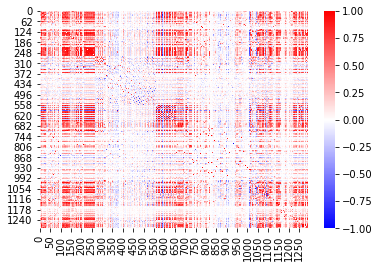

In [13]:
#Remove features that are almost identical to each other (R>0.95)
from scipy.stats import pearsonr
from itertools import combinations
m=train_features.shape[1]
R_mat=np.empty((m,m))
for (i,j) in combinations(range(m), 2):
    r=pearsonr(train_features[:,i], train_features[:,j])
    R_mat[i,j]=r[0]
    R_mat[j,i]=r[0]
for i in range(m):
    R_mat[i,i]=0.    
    
import seaborn as sns
ax= sns.heatmap(R_mat, center=0, cmap='bwr')

R_mat=np.nan_to_num(R_mat, nan=1.)

arr=pd.Series(np.abs(R_mat.flatten()))

print(f"{np.count_nonzero(arr==1)} comparisons with R=1.00")
print(f"{np.count_nonzero(arr>0.95)} comparisons with R>0.95")

# arr=np.where(R_mat==1.)

def split_ind(arr):
    # Given 2D array of pairs of indices, return the lowest index of connected groups of indices
    retain_list=[]
    omit_list=[]
    for i in range(len(arr[0])):
        head, tail=arr[0][i], arr[1][i]
        if head in retain_list:
            omit_list=np.append(omit_list,tail)
        elif tail in retain_list:
            omit_list=np.append(omit_list,head)
        else:
            retain_list=np.append(retain_list, head)
            omit_list=np.append(omit_list,tail)
        retain_list=np.setdiff1d(retain_list, omit_list)
        omit_list=np.unique(omit_list)
    return retain_list, omit_list

retain_list2, omit_list2=split_ind(np.where(np.abs(R_mat)>0.99))

filtered_features=np.setdiff1d(range(m), omit_list2)
train_features_filtered=train_features[:,filtered_features]
test_features_filtered=test_features[:,filtered_features]

print(f"{len(filtered_features)} out of {m} features retained.")

data_cols = data_cols[filtered_features]

In [14]:
all_features = pd.DataFrame(np.vstack([train_features_filtered,
                                       test_features_filtered]), 
                            columns = data_cols
                           )
all_fp = pd.DataFrame(fp, 
                      columns = [f"ECFP{i:4d}" for i in range(fp.shape[1])])
all_features = pd.concat([all_features, all_fp], 
                        axis=1)


In [15]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

train_features = all_features.iloc[:train_features.shape[0],:]

supports=[]
for i in range(train_labels.shape[1]):
    valid_ind = ~np.isnan(train_labels.iloc[:,i].astype(np.float))
    train_target = train_labels[valid_ind].iloc[:,i].values.astype(
        float)
    clf=ExtraTreesClassifier(n_estimators=499, random_state=123)
    clf.fit(train_features[valid_ind], train_target)
    model=SelectFromModel(clf, prefit=True)
    supports.append(model.get_support())


(array([980., 535., 251., 140., 117.,  67.,  46.,  32.,  24.,  22.,  22.,
         40., 722.]),
 array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5,
        10.5, 11.5, 12.5]),
 <BarContainer object of 13 artists>)

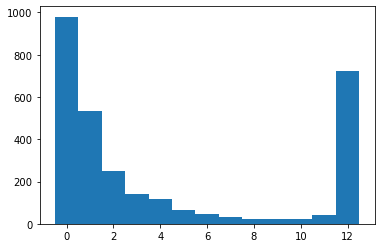

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
counts = np.sum(supports, axis=0)
plt.hist(counts, np.array(list(range(14)))-0.5, )

In [17]:
for i in range(12):
    print(f"Proportion of features that are important in at least {i+1} problem(s): {np.sum(counts>i)/len(counts):.3f}")

Proportion of features that are important in at least 1 problem(s): 0.673
Proportion of features that are important in at least 2 problem(s): 0.495
Proportion of features that are important in at least 3 problem(s): 0.411
Proportion of features that are important in at least 4 problem(s): 0.364
Proportion of features that are important in at least 5 problem(s): 0.325
Proportion of features that are important in at least 6 problem(s): 0.303
Proportion of features that are important in at least 7 problem(s): 0.288
Proportion of features that are important in at least 8 problem(s): 0.277
Proportion of features that are important in at least 9 problem(s): 0.269
Proportion of features that are important in at least 10 problem(s): 0.262
Proportion of features that are important in at least 11 problem(s): 0.254
Proportion of features that are important in at least 12 problem(s): 0.241


In [18]:
thresh = 10
selected_feat_ind = np.where(counts>thresh-0.5)[0]
all_features.index = all_id.index

to_save = all_features.iloc[:, selected_feat_ind]
to_save = pd.concat([all_id, 
                     all_labels, 
                     all_features,
                    ],
                    axis=1
                   )

to_save.to_csv("XY_Tox21_CDKPaDELMorgan2_filtered.csv", 
            )

# Cosa model feature weights calculation (Change to python3 kernel. Skip if reloading)

In [1]:
import pandas as pd
import numpy as np
df = pd.read_csv("XY_Tox21_CDKPaDELMorgan2_filtered.csv",
                 index_col=0
                )
label_start = 5
feat_start = 17
train_ind = np.where(df['Type']=='Training')[0]
test_ind = np.where(df['Type']=='Testing')[0]

train_features = df.iloc[train_ind, feat_start:].values
train_targets = df.iloc[train_ind, label_start:feat_start].values
test_features = df.iloc[test_ind, feat_start:]
test_targets = df.iloc[test_ind, label_start:feat_start]

In [2]:
df.head()

,Type,Molecule name,Canonical_QSARr,InChI_Code_QSARr,InChI Key_QSARr,NR-AR,NR-AhR,NR-AR-LBD,NR-ER,NR-ER-LBD,...,ECFP2038,ECFP2039,ECFP2040,ECFP2041,ECFP2042,ECFP2043,ECFP2044,ECFP2045,ECFP2046,ECFP2047
0,Training,NCGC00166114-03,OC(=O)C1=CC=CC=C1C1C2C=C(Br)C(O)=C(Br)C=2OC2C=...,InChI=1S/C20H8Br4O5/c21-11-5-9-13(7-3-1-2-4-8(...,AZXGXVQWEUFULR-UHFFFAOYSA-N,0.0,0.0,NaN,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Training,NCGC00263563-01,CC1(O)OC(C2CC(OC3CC(OC)C(OC)C(C)O3)C(O2)C2(C)C...,"InChI=1S/C47H80O17/c1-23-18-24(2)45(9,51)61-36...",RWVUEZAROXKXRT-UHFFFAOYSA-N,0.0,0.0,0.0,NaN,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2,Training,NCGC00013058-02,CN(C)C1C=CC(=CC=1)C(C1C=CC=CC=1)=C1C=CC(C=C1)=...,InChI=1S/C23H25N2/c1-24(2)21-14-10-19(11-15-21...,VFCNQNZNPKRXIT-UHFFFAOYSA-N,0.0,1.0,NaN,NaN,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Training,NCGC00167516-01,CC(C)CC(NC(=O)C(CC1=CNC2C=CC=CC=21)NC(=O)C(CC1...,InChI=1S/C64H83N17O12/c1-4-68-62(92)53-16-10-2...,GJKXGJCSJWBJEZ-UHFFFAOYSA-N,0.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Training,NCGC00018301-05,CC(C)SC1=CC=C(C=C1)C(O)C(C)NCCCCCCCC,InChI=1S/C20H35NOS/c1-5-6-7-8-9-10-15-21-17(4)...,BFCDFTHTSVTWOG-UHFFFAOYSA-N,0.0,0.0,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
train_targets

array([[ 0.,  0., nan, ...,  0., nan,  0.],
       [ 0.,  0.,  0., ...,  0., nan,  1.],
       [ 0.,  1., nan, ...,  1.,  1., nan],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.]])

In [ ]:
import os, sys
sys.path.append(os.path.join("..","..","..","scripts"))

from algorithms import COSA
cosa_mdl=COSA.NNCosa(Fweight_init="uniform", lam=0.2, n_iter=20,
                                distance_measure="inv_exp_dist",
                     calc_D_ijk=False, threads=8
                    )
cosa_mdl.fit(train_features)
Fweights_train=cosa_mdl.output_Fweight()
cosa_dist_train=cosa_mdl.output_Dmat()

Starting on outer iteration 1; beta/eta:0.220


In [ ]:
cosa_mdl.fit_OOS(test_features)
Fweights_test = cosa_mdl.output_Fweight(OOS=True)
cosa_dist_test = cosa_mdl.output_Dmat(OOS=True)

In [ ]:
pd.DataFrame(Fweights_train, index=False).to_csv(
    "XY_Tox21_CDKPaDELMorgan2_Fweights_train.csv")
pd.DataFrame(cosa_dist_train, index=False).to_csv(
    "XY_Tox21_CDKPaDELMorgan2_cosa_dist_train.csv"
)
pd.DataFrame(Fweights_test, index=False).to_csv(
    "XY_Tox21_CDKPaDELMorgan2_Fweights_test.csv"
)
pd.DataFrame(cosa_dist_test, index=False).to_csv(
    "XY_Tox21_CDKPaDELMorgan2_cosa_dist_test.csv"
)